# Imports and data extracting

In [6]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
from sklearn.multioutput import MultiOutputClassifier

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from catboost.utils import select_threshold
import pickle

### df_сampaigns -> факт коммуникаций с баерами

In [8]:
df_campaigns = pd.read_feather('campaigns.feather')
df_campaigns.head()

,smt_decision_makerid,delivery_date,hash,campaign_name,segment_name,ab_group,tag_channel,tag_category,tag_campaign_type,tag_product,tag_project_type,tag_project_region,tag_discount_flag,tag_chain_flag,tag_model_flag,target_event,tag_realestate_flag
0,d07201565c46a7ff8544574ad3410cc8,2024-12-05,91e093035c50c368832552e8b174e740,[prod] [batch] [241204] [SMS] Первичная недвиж...,DSML-1844,target,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,not_chain,model,sale,realestate
1,d07201565c46a7ff8544574ad3410cc8,2024-12-03,91e093035c50c368832552e8b174e740,[run] [241031] Первичная недвижимость После зв...,None,target,wa,RealEstate,Active,realestate,not_izhs,all,not_discount,not_chain,not_model,appointment,realestate
2,cd71ba6d85a7e0c379e54892a6b931de,2024-10-02,4df189d22038fd188fef0ec54a9cba6c,[batch] [241002] [SMS] Первичная недвижимость ...,DSML-1814,target,sms,RealEstate,Active,realestate,not_izhs,all,not_discount,not_chain,model,appointment,realestate
3,340dd300a3093e8120264d701ca9f73c,2024-12-03,ef401fc6177a7592861c437cb6ce728b,[batch] [241203] [SMS] [МСК] Первичная недвижи...,CMPG-3843,control,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,chain,not_model,call,realestate
4,340dd300a3093e8120264d701ca9f73c,2024-12-10,ef401fc6177a7592861c437cb6ce728b,[batch] [241203] [SMS] [МСК] Первичная недвижи...,CMPG-3843,control,sms,RealEstate,Active,realestate,not_izhs,mimo,not_discount,chain,not_model,call,realestate


In [9]:
df_campaigns.drop_duplicates(inplace = True)

In [10]:
df_campaigns.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1428378 entries, 0 to 1999635
Data columns (total 17 columns):
 #   Column                Non-Null Count    Dtype 
---  ------                --------------    ----- 
 0   smt_decision_makerid  1428378 non-null  object
 1   delivery_date         1428378 non-null  object
 2   hash                  1428378 non-null  object
 3   campaign_name         1428378 non-null  object
 4   segment_name          1428378 non-null  object
 5   ab_group              1428378 non-null  object
 6   tag_channel           1428378 non-null  object
 7   tag_category          1428378 non-null  object
 8   tag_campaign_type     1428378 non-null  object
 9   tag_product           1428378 non-null  object
 10  tag_project_type      1428378 non-null  object
 11  tag_project_region    1428378 non-null  object
 12  tag_discount_flag     1428378 non-null  object
 13  tag_chain_flag        1428378 non-null  object
 14  tag_model_flag        1428378 non-null  object
 15  tar

In [15]:
df_campaigns['delivery_date'] = pd.to_datetime(df_campaigns['delivery_date'])

In [17]:
df_campaigns['target_event'] = df_campaigns['target_event'].replace({'sale': 'deal'})

In [19]:
df_campaigns = df_campaigns[df_campaigns.target_event.isin(['call','appointment','reservation','deal'])]

In [21]:
df_campaigns['previous_sunday'] = df_campaigns['delivery_date'].apply(lambda x: x - pd.to_timedelta((x.weekday() + 1) % 7, unit='D'))

In [22]:
print(f' Уникальных клиентов в датасете {df_campaigns.smt_decision_makerid.nunique()}')

 Уникальных клиентов в датасете 443774


In [23]:
print(f' Уникальных коммуникаций в датасете {len(df_campaigns)}')

 Уникальных коммуникаций в датасете 1346973


In [24]:
print(f' Коммуникации собраны с {df_campaigns.delivery_date.min()} до {df_campaigns.delivery_date.max()}')

 Коммуникации собраны с 2024-09-02 00:00:00 до 2024-12-31 00:00:00


### df_targets - действия баеров по воронке

In [26]:
df_targets = pd.read_feather('targets.feather')
df_targets.head()

,smt_decision_makerid,report_date,event,tag_event_feature,tag_event_project_type,tag_event_project_region
23,4f9080e1ab09fba6dcbbda752005bde9,2024-10-21 07:52:33,call,outgoing__unknown__secondary,None,None
24,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:39:08,call,outgoing__unknown__secondary,None,None
25,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:35:00,call,ingoing__unknown__primary,None,None
26,4f9080e1ab09fba6dcbbda752005bde9,2024-10-19 13:39:05,decision_maker,None,None,None
28,8c7a245f36d9d5104f14c0edb900d5f5,2024-09-26 12:13:32,decision_maker,None,None,None


In [27]:
df_targets.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1671854 entries, 23 to 7761312
Data columns (total 6 columns):
 #   Column                    Non-Null Count    Dtype         
---  ------                    --------------    -----         
 0   smt_decision_makerid      1671854 non-null  object        
 1   report_date               1671854 non-null  datetime64[ns]
 2   event                     1671854 non-null  object        
 3   tag_event_feature         1303597 non-null  object        
 4   tag_event_project_type    857872 non-null   object        
 5   tag_event_project_region  857872 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 89.3+ MB


In [28]:
df_targets.drop_duplicates(inplace = True)

In [29]:
print(f'Всего ЦД в датасете {len(df_targets)}')

Всего ЦД в датасете 1662142


In [30]:
print(f'Уникальных клиентов в датасете {df_targets.smt_decision_makerid.nunique()}')

Уникальных клиентов в датасете 401628


In [31]:
print(f'Уникальных цд в датасете {df_targets.event.nunique()}')

Уникальных цд в датасете 13


In [32]:
print(f' ЦД собраны с {df_targets.report_date.min()} до {df_targets.report_date.max()}')

 ЦД собраны с 2024-09-01 00:03:59 до 2024-12-31 23:49:47


In [33]:
df_targets.event.value_counts()

event
call              1044409
decision_maker     271063
specific_pick      134872
appointment         71377
wishlist            66628
reservation         20043
deal                16961
sale                14100
residential          8706
mortgage_app         8099
web_app              2977
tradein_app          2841
levelup_app            66
Name: count, dtype: int64

In [34]:
# нам нужны только 4 -> звонок, встреча, бронь, покупка (?)
# call, appointment, reservation, deal

In [35]:
# фильтруем df_targets, оставляя только нужные цд

In [36]:
# объединяю sale и deal
df_targets['event'] = df_targets['event'].replace({'sale': 'deal'})

In [37]:
df_targets = df_targets[df_targets.event.isin(['call', 'appointment','reservation','deal'])]

In [38]:
print(f'Всего ЦД в датасете {len(df_targets)}')

Всего ЦД в датасете 1166890


In [40]:
print(f'Уникальных клиентов в датасете {df_targets.smt_decision_makerid.nunique()}')

Уникальных клиентов в датасете 343719


In [44]:
print(f'Уникальных цд в датасете {df_targets.event.nunique()}')

Уникальных цд в датасете 4


In [46]:
print(f' ЦД собраны с {df_targets.report_date.min()} до {df_targets.report_date.max()}')

 ЦД собраны с 2024-09-01 00:03:59 до 2024-12-31 23:36:16


### duf -> dataframe user features

In [50]:
# до 400 важных фичей на клиента
duf = pd.read_feather('data_for_students_features_sample_400cols.feather')
duf.head()

,specific_picks__g_client__specific_picks__count__180D,specific_picks__g_client__specific_picks__count__365D,specific_picks__g_client__specific_picks__count__THIS_MONTH,specific_picks__g_client__specific_picks__count__ALL_TIME,specific_picks__g_client__sp_buy_rent__count__60D,specific_picks__g_client__sp_buy_rent__count__90D,specific_picks__g_client__sp_buy_rent__count__180D,specific_picks__g_client__sp_buy_rent__count__365D,specific_picks__g_client__sp_buy_rent__count__THIS_MONTH,specific_picks__g_client__sp_buy_rent__count__ALL_TIME,...,wishlists__g_client__crm_objects__smt_sale_price_rooms_2__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__180D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__365D,wishlists__g_client__crm_objects__flag_finishing__avg__avg__ALL_TIME,wishlists__g_client__wl_createdon__min__ALL_TIME,wishlists__g_client__wl_createdon__max__180D,wishlists__g_client__wl_createdon__max__ALL_TIME,smt_decision_makerid_hash,delivery_date,report_date
0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,cf95f46d6f8c1c08090402da8bcc8866,2024-10-16,2024-10-13
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a024eeadd2a9bc8597d91126a11df815,2024-12-18,2024-12-15
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,823fc0f3c42feb6fdfa437ef138f71af,2024-12-09,2024-12-08
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29d749a479f6a50c12f66a66e74f873f,2024-10-29,2024-10-27
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17f4b76507545dab3ace58ecee673269,2024-10-11,2024-10-06


In [58]:
# меняем название на привычный user_id
duf.rename(columns={'smt_decision_makerid_hash': 'smt_decision_makerid'}, inplace=True)

In [62]:
# убираем повторяющиеся фичи, которые получились в результате нескольких рассылок
duf.drop_duplicates(subset=['smt_decision_makerid', 'report_date'], inplace=True)

In [66]:
duf['report_date'] = pd.to_datetime(duf['report_date'])
duf['delivery_date'] = pd.to_datetime(duf['delivery_date'])

In [67]:
# берём строки из duf только до 15.12, потому что таргет до конца 24
duf = duf[duf.report_date<='2024-12-15']

In [68]:
# duf - фичи клиентов на воскресенье, предшествующее коммуникации из df_campaigns
# одна строка - клиент + фичи на дату

In [69]:
duf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1143647 entries, 0 to 1390846
Columns: 363 entries, specific_picks__g_client__specific_picks__count__180D to report_date
dtypes: datetime64[ns](2), float32(360), object(1)
memory usage: 1.6+ GB


In [72]:
print(f' Всего строк в датасете {len(duf)}')

 Всего строк в датасете 1143647


In [73]:
print(f' Уникальных клиентов в датасете {duf.smt_decision_makerid.nunique()}')

 Уникальных клиентов в датасете 435515


In [76]:
print(f' Фичи собраны с {duf.report_date.min()} до {duf.report_date.max()}')

 Фичи собраны с 2024-09-01 00:00:00 до 2024-12-15 00:00:00


In [77]:
duf.drop(columns = 'delivery_date', inplace = True)

# Часть 1. Модель для оценки склонности

### Описание

In [88]:
# На 1 этапе я хочу оценить склонности баеров к целевым действиям

# Архитектура скоринга:

# - Берём те данные по юзерам, по которым сейчас есть фичи

# - Для каждой такой строки:

# Формируем отдельные таргеты для каждого ЦД:
#     y_call = 1, если звонок в следующие 7 дней
#     y_meeting = 1, если встреча в следующие 7 дней
#     y_reservation = 1, если бронь в 14 дней
#     y_purchase = 1, если покупка в 14 дней

# Пример строки = "срез фич клиента на 2025-03-29", 4 таргета по ЦД по факту ЦД за последующие 2 недели

# Вопросы и ответы:

# 1. Как быть с теми, с кем коммуницировали? -> коммуницируем практически со всеми, поэтому закрываем на это глаза
# 2. Как быть с теми, у кого уже была, например, встреча? -> не учитываем повторные целевые действия

In [90]:
# на вход -> фичи клиента на дату N

# на выходе -> целевое действие с максимальной вероятностью (все вероятности цд)

### Шаг 1 -> подготовка данных

In [93]:
# привести данные в формат
# клиент | фича 1 | фича 2 | ... | факт ЦД 1 в ближайшие X дней | факт ЦД 2 в ближайшие X дней | 

In [1557]:
# user_id -> smt_decision_makerid_hash

In [1559]:
main_camp_features = ['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']

In [1561]:
# user features with communication
# одна строка - smt_decision_makerid+report_date+delivery_date

df_uf_w_com = duf.merge(df_campaigns[['smt_decision_makerid','delivery_date','previous_sunday']+main_camp_features],
        left_on = ['smt_decision_makerid','report_date'], right_on = ['smt_decision_makerid','previous_sunday'])

In [1562]:
# теперь надо посчитать факт целевого действия в окнах от delivery_date
df_del = df_uf_w_com[['smt_decision_makerid','delivery_date']].copy()

df_del['end_date_7'] = df_del['delivery_date'] + pd.Timedelta(days=7)
df_del['end_date_14'] = df_del['delivery_date'] + pd.Timedelta(days=14)

# Переименуем поля, чтобы не было конфликтов при merge
df_targets_renamed = df_targets.rename(columns={'report_date': 'event_date'})

In [1563]:
# Сделаем merge по user_id, затем отфильтруем по диапазону дат
merged = df_del.merge(df_targets_renamed, on='smt_decision_makerid', how='left')
merged = merged[
    # цд после коммуникации
    (merged['event_date'] >= merged['delivery_date']) & 
    # для звонка и встречи окно 7 дней
    (((merged['event'].isin(['call','appointment'])) & (merged['event_date'] <= merged['end_date_7'])) | 
    # для брони и сделки 14 дней
    ((merged['event'].isin(['reservation','deal'])) & (merged['event_date'] <= merged['end_date_14'])))
]

In [1564]:
# Создадим сводную таблицу, где по каждой записи в df_del будет указано наличие события
event_flags = (
    merged.groupby(['smt_decision_makerid', 'delivery_date', 'event']).size()
    .unstack(fill_value=0) # в df 
    .clip(upper=1)  # превращаем количество в 1/0
    .reset_index()
)

In [1565]:
# Объединим с исходной таблицей
final_data = df_uf_w_com.merge(event_flags, on=['smt_decision_makerid', 'delivery_date'], how='left')

# final_data NaN на 0 — там, где не было совпадений
final_data[['call', 'appointment', 'reservation', 'deal']] = final_data[
    ['call', 'appointment', 'reservation', 'deal']
].fillna(0).astype(int)

final_data

,specific_picks__g_client__specific_picks__count__180D,specific_picks__g_client__specific_picks__count__365D,specific_picks__g_client__specific_picks__count__THIS_MONTH,specific_picks__g_client__specific_picks__count__ALL_TIME,specific_picks__g_client__sp_buy_rent__count__60D,specific_picks__g_client__sp_buy_rent__count__90D,specific_picks__g_client__sp_buy_rent__count__180D,specific_picks__g_client__sp_buy_rent__count__365D,specific_picks__g_client__sp_buy_rent__count__THIS_MONTH,specific_picks__g_client__sp_buy_rent__count__ALL_TIME,...,previous_sunday,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag,appointment,call,deal,reservation
0,1.0,1.0,0.0,2.0,0.0,0.0,1.0,1.0,0.0,2.0,...,2024-10-13,call,nbo,not_izhs,not_chain,not_model,0,0,0,0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-12-15,call,realestate,not_izhs,chain,not_model,0,0,0,0
2,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,...,2024-12-08,deal,mortgage,not_izhs,not_chain,model,0,0,0,0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-27,call,realestate,not_izhs,chain,not_model,0,0,0,0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-06,call,realestate,not_izhs,chain,not_model,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1136107,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2024-09-29,deal,realestate,not_izhs,not_chain,model,0,0,0,0
1136108,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,2024-09-29,call,realestate,not_izhs,not_chain,not_model,0,0,0,0
1136109,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,...,2024-10-06,call,nbo,not_izhs,not_chain,not_model,0,0,0,0
1136110,2.0,2.0,0.0,2.0,0.0,0.0,2.0,2.0,0.0,2.0,...,2024-12-15,call,realestate,not_izhs,chain,not_model,0,0,0,0


In [1566]:
# оставляю коммуникации только как в filtered_camps

# Делю на 2 ноута:

# 1. Этот - тупо скоринг по вероятности сделки 

# 2. По юзеру предсказываю склонность, дальше бизнес-правила и выбираю оффер по цд

In [1567]:
# campaign_filters = (final_data.tag_channel == 'sms')&(final_data.target_event != 'reservation')

In [1568]:
main_camp_features = ['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']

In [1569]:
# res_camps = final_data.groupby(all_camp_features)[['delivery_date']].agg(['max', 'min','count']).reset_index()
res_camps = final_data.groupby(main_camp_features)[['delivery_date']].agg(['max', 'min','count']).reset_index()

In [1570]:
res_camps.rename(columns={'min': 'min_dt', 
                        'max': 'max_dt',
                        'count': 'camps'}, inplace = True)

In [1573]:
res_camps[(res_camps.delivery_date.max_dt >= '2024-12-15')&(res_camps.delivery_date.min_dt < '2024-12-08')].delivery_date.camps.sum()

720778

In [1576]:
filtered_camps = res_camps[(((res_camps.delivery_date.max_dt >= '2024-12-08')&(res_camps.delivery_date.min_dt < '2024-12-08'))\
            | ((res_camps.target_event == 'deal')&(res_camps.tag_product == 'realestate')))
            & (res_camps.tag_product != 'lost_leads')].drop('delivery_date', axis = 1)

/var/folders/z2/2_vkl0857zddhqnj2vn7yx440000gn/T/ipykernel_15369/3436734710.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  & (res_camps.tag_product != 'lost_leads')].drop('delivery_date', axis = 1)


In [1577]:
filtered_camps

,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
,,,,,
2,appointment,nbo,not_izhs,not_chain,not_model
5,appointment,realestate,not_izhs,not_chain,not_model
8,call,commercial,not_izhs,chain,not_model
10,call,izhs,izhs,chain,not_model
11,call,mortgage,not_izhs,not_chain,not_model
14,call,realestate,not_izhs,chain,not_model
18,deal,mortgage,not_izhs,not_chain,model
19,deal,realestate,not_izhs,not_chain,model
22,reservation,not_defined,not_izhs,not_chain,not_model


In [1587]:
filtered_camps.columns = filtered_camps.columns.droplevel(1)

In [1589]:
filtered_camps.reset_index(drop=True, inplace = True)

In [1591]:
filtered_camps

,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,appointment,nbo,not_izhs,not_chain,not_model
1,appointment,realestate,not_izhs,not_chain,not_model
2,call,commercial,not_izhs,chain,not_model
3,call,izhs,izhs,chain,not_model
4,call,mortgage,not_izhs,not_chain,not_model
5,call,realestate,not_izhs,chain,not_model
6,deal,mortgage,not_izhs,not_chain,model
7,deal,realestate,not_izhs,not_chain,model
8,reservation,not_defined,not_izhs,not_chain,not_model
9,reservation,realestate,not_izhs,not_chain,model


In [1593]:
final_data = final_data.merge(filtered_camps)

In [1594]:
train_full = final_data[final_data.report_date < '2024-12-08']

X_train = train_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid'
    ,'report_date','delivery_date','previous_sunday'
    ,'target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']).to_numpy()

y_train = train_full[['call','appointment','reservation','deal']].to_numpy()

In [1595]:
train_full[['call','appointment','reservation','deal']].mean()

call           0.057921
appointment    0.013944
reservation    0.004647
deal           0.003848
dtype: float64

In [1596]:
val_full = final_data[final_data.report_date == '2024-12-08']

X_val = val_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid'
    ,'report_date','delivery_date','previous_sunday'
    ,'target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']).to_numpy()
y_val = val_full[['call','appointment','reservation','deal']].to_numpy()

In [1598]:
val_full[['call','appointment','reservation','deal']].mean()

call           0.050911
appointment    0.012710
reservation    0.004132
deal           0.003496
dtype: float64

In [1599]:
test_full = final_data[final_data.report_date > '2024-12-08']

X_test = test_full.drop(columns=['call','appointment','deal','reservation','smt_decision_makerid'
    ,'report_date','delivery_date','previous_sunday'
    ,'target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']).to_numpy()
y_test = test_full[['call','appointment','reservation','deal']].to_numpy()

In [1605]:
# меньше CR на тесте, близко к нг - праздники
test_full[['call','appointment','reservation','deal']].mean()

call           0.032880
appointment    0.006589
reservation    0.002543
deal           0.002739
dtype: float64

In [1607]:
len(X_train), len(X_val), len(X_test)

(534557, 114711, 169069)

### Шаг 2 -> строим модель

In [326]:
params = {
    # база для любой модели
    'iterations':    500,
    'learning_rate': 0.02,
    'random_state':42,
    'early_stopping_rounds': 20,
    'verbose':50,
    # метрики для предсказания нескольких классов 
    'loss_function': 'MultiCrossEntropy',
    'eval_metric':   'MultiCrossEntropy',
    # боремся с переобучением
    'use_best_model': True,
    'depth':         6,
    'l2_leaf_reg':   4,
    # 'bootstrap_type':'Bernoulli',
    # 'subsample':     0.8,
    # для лучшей работы с несколькими классами
    
    'class_names':['call', 'appointment', 'reservation', 'deal']
}

In [328]:
ta_model = CatBoostClassifier(**params)

In [330]:
ta_model.fit(X_train, y_train,
        eval_set=(X_val, y_val),
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6475442	test: 0.6469033	best: 0.6469033 (0)	total: 389ms	remaining: 3m 14s
50:	learn: 0.0919683	test: 0.0982309	best: 0.0982309 (50)	total: 19.4s	remaining: 2m 50s
100:	learn: 0.0691686	test: 0.0839612	best: 0.0829610 (84)	total: 40s	remaining: 2m 38s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.08296099189
bestIteration = 84

Shrink model to first 85 iterations.


In [331]:
test_predict = ta_model.predict(X_test)
probs = ta_model.predict_proba(X_test)


Target: call
AUC       : 0.791
Trashhold = default 0.5
Accuracy  : 0.971
Precision : 0.762
Recall    : 0.172
F1-score  : 0.281

Target: appointment
AUC       : 0.744
Trashhold = default 0.5
Accuracy  : 0.993
Precision : 0.000
Recall    : 0.000
F1-score  : 0.000

Target: reservation
AUC       : 0.754
Trashhold = default 0.5
Accuracy  : 0.997
Precision : 0.000
Recall    : 0.000
F1-score  : 0.000

Target: deal
AUC       : 0.792
Trashhold = default 0.5
Accuracy  : 0.997
Precision : 0.000
Recall    : 0.000
F1-score  : 0.000

Average Metrics:
AUC       : 0.7704
Accuracy  : 0.9898
Precision : 0.1904
Recall    : 0.0431
F1-score  : 0.0703


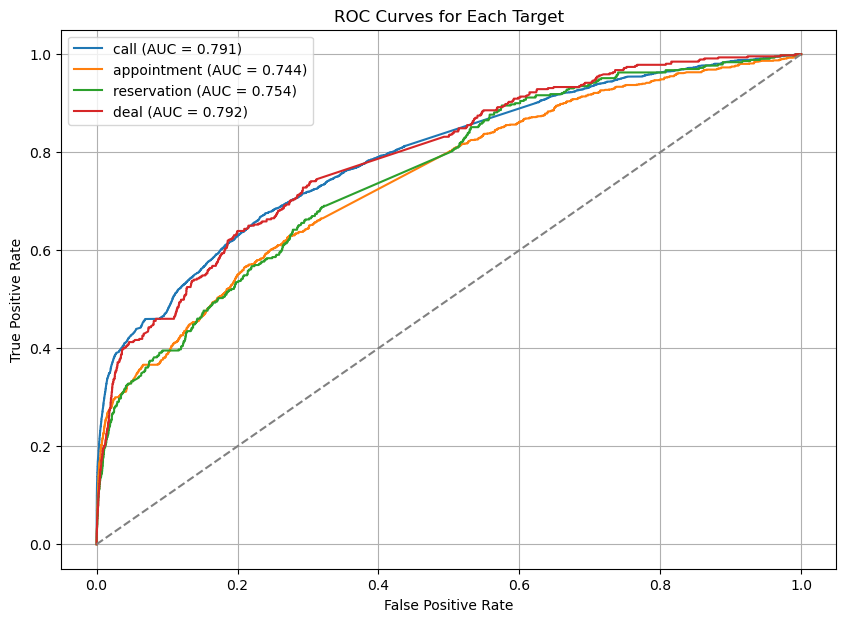

In [333]:
# Метрики и графики для каждого таргета
def plot_roc_curve(y_true, y_pred, label):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr, label=f'{label} (AUC = {roc_auc_score(y_true, y_pred):.3f})')

test_auc, test_acc, test_prec, test_rec, test_f1 = [], [], [], [], []

plt.figure(figsize=(10, 7))
for i, target in enumerate(ta_model.classes_):
    y_true = y_test[:,i]
    y_prob = probs[:,i]
    y_pred = (y_prob >= 0.5).astype(int)

    # Метрики 
    auc = roc_auc_score(y_true, y_prob)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    test_auc.append(auc)
    test_acc.append(acc)
    test_prec.append(prec)
    test_rec.append(rec)
    test_f1.append(f1)

    print(f"\nTarget: {target}")
    print(f"AUC       : {auc:.3f}")
    print(f"Trashhold = default 0.5")
    print(f"Accuracy  : {acc:.3f}")
    print(f"Precision : {prec:.3f}")
    print(f"Recall    : {rec:.3f}")
    print(f"F1-score  : {f1:.3f}")

    # Рисуем ROC
    plot_roc_curve(y_true, y_prob, target)
    
# Общий вывод
print("\nAverage Metrics:")
print(f"AUC       : {np.mean(test_auc):.4f}")
print(f"Accuracy  : {np.mean(test_acc):.4f}")
print(f"Precision : {np.mean(test_prec):.4f}")
print(f"Recall    : {np.mean(test_rec):.4f}")
print(f"F1-score  : {np.mean(test_f1):.4f}")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Target')
plt.legend()
plt.grid(True)
plt.show()

In [334]:
ta_model.save_model('ta_model_2.bin')

In [149]:
# ta_model = CatBoostClassifier()
# ta_model.load_model('ta_model_2.bin')
# print(ta_model.get_params())

{'use_best_model': True, 'class_names': ['call', 'appointment', 'reservation', 'deal'], 'eval_metric': 'MultiCrossEntropy', 'od_wait': 20, 'verbose': 50, 'iterations': 500, 'loss_function': 'MultiCrossEntropy', 'l2_leaf_reg': 4, 'depth': 6, 'random_seed': 42, 'learning_rate': 0.02}


# Часть 2. Определяем тип ЦД для каждого юзера+дата, добавляя проверку на повторы

### 1) Предсказания модели на тесте

In [1609]:
probs = ta_model.predict_proba(X_test)

In [1611]:
test_full = final_data[final_data.report_date > '2024-12-08']
test_full.reset_index(drop=True, inplace = True)

In [1613]:
df_probs = pd.DataFrame({col: probs[:, i] for i, col in enumerate(['call_score','appointment_score','reservation_score','deal_score'])})
df_probs

,call_score,appointment_score,reservation_score,deal_score
0,0.052478,0.019821,0.008617,0.007171
1,0.035005,0.011168,0.006730,0.005903
2,0.052100,0.016511,0.006870,0.005735
3,0.049137,0.016033,0.007483,0.005755
4,0.052211,0.017353,0.006437,0.004874
...,...,...,...,...
169064,0.052478,0.019821,0.008617,0.007171
169065,0.052478,0.019821,0.008617,0.007171
169066,0.059068,0.018641,0.008652,0.007221
169067,0.052478,0.019821,0.008617,0.007171


In [1615]:
test_full = test_full.merge(df_probs, left_index=True, right_index=True)

### 2) Факт наличия ЦД раньше для всех клиентов+дат

In [1618]:
test_ = test_full[['smt_decision_makerid','delivery_date']].drop_duplicates().copy()

In [1620]:
test_

,smt_decision_makerid,delivery_date
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16
4,42358f2cf5e091a253a54259e058b855,2024-12-18
...,...,...
169064,2fafb2d053c7d717ab053a5252ad8316,2024-12-19
169065,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19
169066,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19
169067,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19


In [1622]:
test_['before_date_14'] = test_['delivery_date'] - pd.Timedelta(days=90)

In [1624]:
# изначально пусть все по дефолту 1 - т.е. таргетов не было
# если будут, то будем вычитать 1
test_['call_before'] = 1
test_['appointment_before'] = 1
test_['reservation_before'] = 1
test_['deal_before'] = 1

In [1626]:
test_merged = test_.merge(df_targets_renamed, on='smt_decision_makerid', how='left')

In [1627]:
# цд до сбора фичей
test_merged = test_merged[(test_merged['event_date'] < test_merged['delivery_date'])&(test_merged['event_date'] >= test_merged['before_date_14'])]

In [1630]:
# по 1 строке на факт наличия цд 1 типа, так как нам важно просто флаг - было или нет
test_merged = test_merged[['smt_decision_makerid','delivery_date','event']].drop_duplicates()

In [1632]:
df_ohe = pd.get_dummies(test_merged, columns=['event'])

In [1634]:
df_ohe = df_ohe.groupby(['smt_decision_makerid', 'delivery_date']).max().reset_index()

In [1636]:
df_ohe

,smt_decision_makerid,delivery_date,event_appointment,event_call,event_deal,event_reservation
0,00002a7fb1adf44e0bd425d61c8e4773,2024-12-16,False,True,True,True
1,0004f60ade13d1ee3ab07d88521619d6,2024-12-16,False,True,False,False
2,00050fbf9b4ef349d47860154b8e631f,2024-12-16,False,True,False,False
3,0005989c6100b94982e32536ed04c6fa,2024-12-18,False,True,False,False
4,000765771505f7017f7928383160a1cd,2024-12-18,False,True,False,False
...,...,...,...,...,...,...
56374,fff7be603390acc6230485f1f4a6445d,2024-12-20,True,True,False,False
56375,fffaa186cf331db23a0933960a6921e7,2024-12-16,False,True,False,False
56376,fffce9f27210e196f6b31e1737de8e84,2024-12-16,True,True,False,False
56377,fffd8a41ef09760ac991734a507e4b22,2024-12-20,False,True,False,False


In [1638]:
cols = ['event_call','event_appointment','event_reservation','event_deal']

df_ohe[cols] = df_ohe[cols].replace({True: -1, False: 0})

In [1640]:
test_ = test_.merge(df_ohe, on=['smt_decision_makerid','delivery_date'], how='left').fillna(0)

In [1642]:
test_

,smt_decision_makerid,delivery_date,before_date_14,call_before,appointment_before,reservation_before,deal_before,event_appointment,event_call,event_deal,event_reservation
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,2024-09-19,1,1,1,1,0.0,0.0,0.0,0.0
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,2024-09-19,1,1,1,1,0.0,0.0,0.0,0.0
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,2024-09-19,1,1,1,1,0.0,0.0,0.0,0.0
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,2024-09-17,1,1,1,1,0.0,0.0,0.0,0.0
4,42358f2cf5e091a253a54259e058b855,2024-12-18,2024-09-19,1,1,1,1,0.0,-1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
168802,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,2024-09-20,1,1,1,1,0.0,0.0,0.0,0.0
168803,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,2024-09-20,1,1,1,1,0.0,0.0,0.0,0.0
168804,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,2024-09-20,1,1,1,1,0.0,0.0,0.0,0.0
168805,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,2024-09-20,1,1,1,1,0.0,-1.0,0.0,0.0


In [1644]:
test_['call_before_mult'] = (test_['call_before'] + test_['event_call']).astype(int)
test_['appointment_before_mult'] = (test_['appointment_before'] + test_['event_appointment']).astype(int)
test_['reservation_before_mult'] = (test_['reservation_before'] + test_['event_reservation']).astype(int)
test_['deal_before_mult'] = (test_['deal_before'] + test_['event_deal']).astype(int)

In [1646]:
#3) Веса для ЦД

In [1648]:
# звонок - 0.2
# встреча - 0.4
# бронь - 0.6
# покупка - 1

In [1650]:
test_['call_before_mult'] = test_['call_before_mult'] * 0.2
test_['appointment_before_mult'] = test_['appointment_before_mult'] * 0.4
test_['reservation_before_mult'] = test_['reservation_before_mult'] * 0.6

In [1652]:
test_ = test_[['smt_decision_makerid', 'delivery_date',
    'call_before_mult', 'appointment_before_mult', 'reservation_before_mult','deal_before_mult']]

In [1654]:
# в таблице множители для скоров
# домножаем на 1, если ЦД раньше не было, то есть всё норм
# домножаем на 0, если ЦД раньше было - т.е. не рассматриваем
test_



,smt_decision_makerid,delivery_date,call_before_mult,appointment_before_mult,reservation_before_mult,deal_before_mult
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,0.2,0.4,0.6,1
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,0.2,0.4,0.6,1
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,0.2,0.4,0.6,1
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,0.2,0.4,0.6,1
4,42358f2cf5e091a253a54259e058b855,2024-12-18,0.0,0.4,0.6,1
...,...,...,...,...,...,...
168802,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,0.2,0.4,0.6,1
168803,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,0.2,0.4,0.6,1
168804,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,0.2,0.4,0.6,1
168805,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,0.0,0.4,0.6,1


In [1656]:
test_['call_before_mult'] = test_[['call_before_mult', 'appointment_before_mult','reservation_before_mult']].min(axis=1)

/var/folders/z2/2_vkl0857zddhqnj2vn7yx440000gn/T/ipykernel_15369/1499834219.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_['call_before_mult'] = test_[['call_before_mult', 'appointment_before_mult','reservation_before_mult']].min(axis=1)


In [1658]:
test_['appointment_before_mult'] = test_[['appointment_before_mult','reservation_before_mult']].min(axis=1)

/var/folders/z2/2_vkl0857zddhqnj2vn7yx440000gn/T/ipykernel_15369/1087733205.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_['appointment_before_mult'] = test_[['appointment_before_mult','reservation_before_mult']].min(axis=1)


### 3) Объединяем -> получаем реальные типы ЦД, которые передаем дальше

In [1662]:
test_full.columns[360:]

Index(['smt_decision_makerid', 'report_date', 'delivery_date',
       'previous_sunday', 'target_event', 'tag_product', 'tag_project_type',
       'tag_chain_flag', 'tag_model_flag', 'appointment', 'call', 'deal',
       'reservation', 'call_score', 'appointment_score', 'reservation_score',
       'deal_score'],
      dtype='object')

In [1664]:
# test_main_fcst = test_full[['smt_decision_makerid', 'delivery_date', 
#     'target_event','tag_product','tag_project_type', 'tag_chain_flag', 'tag_model_flag']]
#     #'call_score', 'appointment_score', 'reservation_score','deal_score']]

In [1666]:
df_res_1_step = pd.merge(test_full[['smt_decision_makerid', 'delivery_date','target_event', 'call_score', 'appointment_score', 'reservation_score','deal_score']]
        , test_, how = 'inner', on = ['smt_decision_makerid','delivery_date'])

In [1668]:
df_res_1_step['call_res'] = df_res_1_step['call_score'] * df_res_1_step['call_before_mult'] 
df_res_1_step['appointment_res'] = df_res_1_step['appointment_score'] * df_res_1_step['appointment_before_mult'] 
df_res_1_step['reservation_res'] = df_res_1_step['reservation_score'] * df_res_1_step['reservation_before_mult'] 
df_res_1_step['deal_res'] = df_res_1_step['deal_score'] * df_res_1_step['deal_before_mult'] 

In [1670]:
df_res_1_step

,smt_decision_makerid,delivery_date,target_event,call_score,appointment_score,reservation_score,deal_score,call_before_mult,appointment_before_mult,reservation_before_mult,deal_before_mult,call_res,appointment_res,reservation_res,deal_res
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,call,0.052478,0.019821,0.008617,0.007171,0.2,0.4,0.6,1,0.010496,0.007929,0.005170,0.007171
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,call,0.035005,0.011168,0.006730,0.005903,0.2,0.4,0.6,1,0.007001,0.004467,0.004038,0.005903
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,call,0.052100,0.016511,0.006870,0.005735,0.2,0.4,0.6,1,0.010420,0.006604,0.004122,0.005735
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,call,0.049137,0.016033,0.007483,0.005755,0.2,0.4,0.6,1,0.009827,0.006413,0.004490,0.005755
4,42358f2cf5e091a253a54259e058b855,2024-12-18,call,0.052211,0.017353,0.006437,0.004874,0.0,0.4,0.6,1,0.000000,0.006941,0.003862,0.004874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
169064,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,call,0.052478,0.019821,0.008617,0.007171,0.2,0.4,0.6,1,0.010496,0.007929,0.005170,0.007171
169065,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,call,0.052478,0.019821,0.008617,0.007171,0.2,0.4,0.6,1,0.010496,0.007929,0.005170,0.007171
169066,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,call,0.059068,0.018641,0.008652,0.007221,0.2,0.4,0.6,1,0.011814,0.007457,0.005191,0.007221
169067,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,call,0.052478,0.019821,0.008617,0.007171,0.0,0.4,0.6,1,0.000000,0.007929,0.005170,0.007171


In [1684]:
len(df_res_1_step[(df_res_1_step.target_event=='call')])

113611

In [1676]:
len(df_res_1_step[(df_res_1_step.target_event=='call')&(df_res_1_step.call_before_mult==0)])

40285

In [1686]:
40/113

0.35398230088495575

In [214]:
cols_score = ['call_score', 'appointment_score', 'reservation_score', 'deal_score']

In [216]:
# макс прогноз модели без учета повторов
df_res_1_step['event_fcst'] = df_res_1_step[cols_score].idxmax(axis=1)

In [218]:
df_res_1_step['event_fcst'] = df_res_1_step['event_fcst'].apply(lambda x : x.replace('_score',''))

In [220]:
df_res_1_step.event_fcst.value_counts()

event_fcst
call    169069
Name: count, dtype: int64

In [222]:
cols_res = ['call_res', 'appointment_res', 'reservation_res', 'deal_res']

In [224]:
# поле с максимумом
df_res_1_step['event_res'] = df_res_1_step[cols_res].idxmax(axis=1)

In [226]:
df_res_1_step['event_res'] = df_res_1_step['event_res'].apply(lambda x : x.replace('_res',''))

In [228]:
df_res_1_step.event_res.value_counts()

event_res
call           113164
appointment     36007
deal            19823
reservation        75
Name: count, dtype: int64

In [230]:
df_res_1_step[['smt_decision_makerid','delivery_date','target_event','event_res']]

,smt_decision_makerid,delivery_date,target_event,event_res
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,call,call
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,call,call
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,call,call
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,call,call
4,42358f2cf5e091a253a54259e058b855,2024-12-18,call,appointment
...,...,...,...,...
169064,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,call,call
169065,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,call,call
169066,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,call,call
169067,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,call,appointment


### 4) Проверка с фактом

In [233]:
# Наличие коммуникации с предсказанным ЦД в следующую неделю после report_date

In [235]:
df_res_1_step[['smt_decision_makerid','delivery_date','target_event','event_res']]

,smt_decision_makerid,delivery_date,target_event,event_res
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,call,call
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,call,call
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,call,call
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,call,call
4,42358f2cf5e091a253a54259e058b855,2024-12-18,call,appointment
...,...,...,...,...
169064,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,call,call
169065,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,call,call
169066,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,call,call
169067,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,call,appointment


In [1549]:
df_res_1_step.target_event.value_counts(normalize=True)

target_event
call           0.671980
appointment    0.202385
reservation    0.125635
Name: proportion, dtype: float64

In [1551]:
df_res_1_step.event_res.value_counts(normalize=True)

event_res
call           0.669336
appointment    0.212972
deal           0.117248
reservation    0.000444
Name: proportion, dtype: float64

# Часть 3. Модели для выбора оффера

In [243]:
def model_metrics(scores, predictions, y_true):

    print(f"\nAUC:     {roc_auc_score(y_true, scores):.3f}")
    print(f"Accuracy:  {accuracy_score(y_true, predictions):.3f}")
    print(f"Precision: {precision_score(y_true, predictions):.3f}")
    print(f"Recall:    {recall_score(y_true, predictions):.3f}")
    print(f"F1 Score:  {f1_score(y_true, predictions):.3f}")

### Call

#### Делим выборки

In [251]:
# [['call','appointment','reservation','deal']]

In [253]:
train_full = final_data[final_data.report_date < '2024-12-08']
val_full = final_data[final_data.report_date == '2024-12-08']
test_full = final_data[final_data.report_date > '2024-12-08']

In [255]:
ta = 'call'

In [257]:
X_train = train_full[train_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

y_train = train_full[train_full.target_event == ta][[ta]].to_numpy()

In [258]:
X_val = val_full[val_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

y_val = val_full[val_full.target_event == ta][[ta]].to_numpy()

In [259]:
X_test = test_full[test_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

y_test = test_full[test_full.target_event == ta][[ta]].to_numpy()

In [260]:
len(X_train), len(X_val), len(X_test), 

(399552, 96467, 113611)

#### Обучаем модель

In [266]:
cat_features = [360, 361, 362, 363]

In [268]:
params = {
    # база для любой модели
    'iterations':   1000,
    'learning_rate': 0.05,
    'random_state':42,
    'verbose':50,
    'cat_features':cat_features,
    'loss_function': 'CrossEntropy',
    'eval_metric':   'AUC',
    # боремся с переобучением
    'use_best_model': True,
    'early_stopping_rounds': 50,
    'depth':         8,
    'l2_leaf_reg':   4,
}

In [270]:
eval_pool = Pool(X_val, y_val, cat_features=cat_features)

In [271]:
call_model = CatBoostClassifier(**params)

In [272]:
call_model.fit(X_train, y_train,
        eval_set=eval_pool,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	test: 0.7890634	best: 0.7890634 (0)	total: 255ms	remaining: 4m 15s
50:	test: 0.8396270	best: 0.8396270 (50)	total: 8.32s	remaining: 2m 34s
100:	test: 0.8446725	best: 0.8446742 (98)	total: 15.5s	remaining: 2m 17s
150:	test: 0.8487015	best: 0.8487015 (150)	total: 22.6s	remaining: 2m 7s
200:	test: 0.8501165	best: 0.8501165 (200)	total: 29.7s	remaining: 1m 58s
250:	test: 0.8505083	best: 0.8507673 (227)	total: 36.6s	remaining: 1m 49s
300:	test: 0.8506563	best: 0.8510060 (259)	total: 43.5s	remaining: 1m 41s
Stopped by overfitting detector  (50 iterations wait)

bestTest = 0.8510059879
bestIteration = 259

Shrink model to first 260 iterations.


In [275]:
# CM
# True Negative False Positive
# False Negative True Positive

# Precision - доля корректно отгаданных 1 относительно всех признанных 1
# Recall - доля корректно отгаданных 1 среди всех 1 в выборке

# Чем больше Precision, тем больше уверенности в случае, когда мы признали 1 
# Чем больше Recall, тем больше 1 мы угадали

In [276]:
# нам логично максимизировать Recall
# определим границу, как 20% 

In [277]:
fnr_boundary = select_threshold(model=call_model, data=eval_pool, FNR=0.1)

Cannot restore border parameter, falling to default border = 0.5


In [278]:
call_model.set_probability_threshold(fnr_boundary)

In [279]:
call_model.save_model('model_call.bin')
# call_model = CatBoostClassifier()
# call_model.load_model('model_call.bin')
# print(call_model.get_params())

#### Считаем метрики

In [280]:
# VAL датасет

In [281]:
probs = call_model.predict_proba(X_val)[:,1]
preds = call_model.predict(X_val)

In [282]:
model_metrics(probs,preds,y_val)


AUC:     0.851
Accuracy:  0.544
Precision: 0.041
Recall:    0.901
F1 Score:  0.078


In [283]:
# Test сет

In [284]:
probs = call_model.predict_proba(X_test)[:,1]
preds = call_model.predict(X_test)

In [285]:
model_metrics(probs,preds,y_test)


AUC:     0.841
Accuracy:  0.464
Precision: 0.030
Recall:    0.895
F1 Score:  0.058


In [579]:
0.901 - 0.895

0.006000000000000005

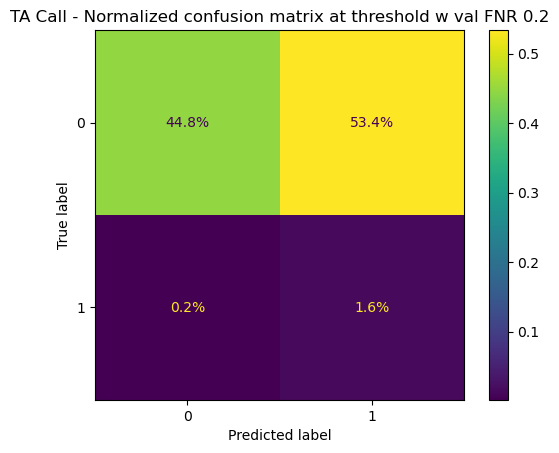

In [286]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
cm_normalized = cm.astype('float') / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(values_format=".1%")  # формат процентов
plt.title(f'TA Call - Normalized confusion matrix at threshold w val FNR 0.2')
plt.show()

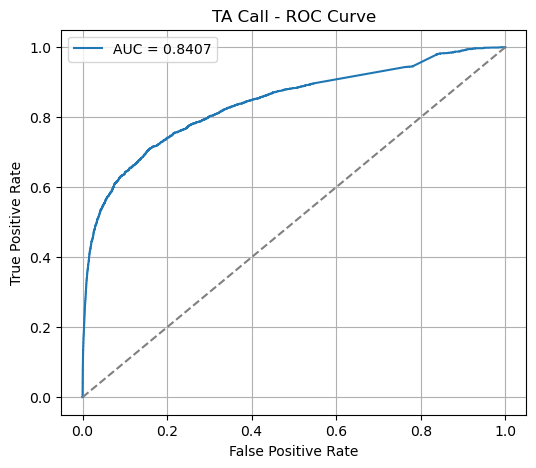

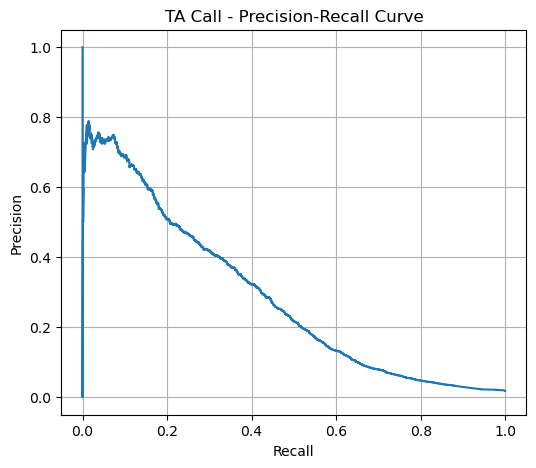

In [287]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('TA Call - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# PR-кривая
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title('TA Call - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


### Appointment

#### Делим выборки

In [302]:
# [['call','appointment','reservation','deal']]

In [304]:
train_full = final_data[final_data.report_date <= '2024-12-08']
# val_full = final_data[final_data.report_date == '2024-12-08']
test_full = final_data[final_data.report_date > '2024-12-08']

In [306]:
ta = 'appointment'

In [308]:
X_train = train_full[train_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

y_train = train_full[train_full.target_event == ta][[ta]].to_numpy()

In [310]:
# X_val = val_full[val_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
#     ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

# y_val = val_full[val_full.target_event == ta][[ta]].to_numpy()

In [312]:
X_test = test_full[test_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

y_test = test_full[test_full.target_event == ta][[ta]].to_numpy()

In [316]:
len(X_train), len(X_test), 

(59286, 34217)

In [318]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)

#### Обучаем модель

In [321]:
cat_features = [360, 361, 362, 363]

In [323]:
params = {
    # база для любой модели
    'iterations':   250,
    'learning_rate': 0.03,
    'random_state':42,
    'verbose':100,
    'cat_features':cat_features,
    'loss_function': 'CrossEntropy', 
    'eval_metric':   'AUC',
    # боремся с переобучением
    # 'use_best_model': True,
    'early_stopping_rounds': 100,
    'depth':         6,
    'l2_leaf_reg':   10,
}

In [325]:
# eval_pool = Pool(X_val, y_val, cat_features=cat_features)

In [327]:
ap_model = CatBoostClassifier(**params)

In [329]:
ap_model.fit(X_train, y_train,
        # eval_set=eval_pool,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	total: 22.9ms	remaining: 5.7s
100:	total: 1.74s	remaining: 2.56s
200:	total: 3.37s	remaining: 821ms
249:	total: 4.17s	remaining: 0us


In [331]:
# нам логично максимизировать Recall
# определим границу, как 20% 

In [333]:
fnr_boundary = select_threshold(model=ap_model, data=train_pool, FNR=0.1)

Cannot restore border parameter, falling to default border = 0.5


In [335]:
ap_model.set_probability_threshold(fnr_boundary)

In [337]:
ap_model.save_model('model_ap.bin')
# ap_model = CatBoostClassifier()
# ap_model.load_model('model_ap.bin')
# print(ap_model.get_params())

#### Считаем метрики

In [340]:
# Train датасет

In [342]:
probs = ap_model.predict_proba(X_train)[:,1]
preds = ap_model.predict(X_train)

In [343]:
model_metrics(probs,preds,y_train)


AUC:     0.891
Accuracy:  0.781
Precision: 0.271
Recall:    0.900
F1 Score:  0.417


In [346]:
# Test сет

In [348]:
probs = ap_model.predict_proba(X_test)[:,1]
preds = ap_model.predict(X_test)

In [349]:
model_metrics(probs,preds,y_test)


AUC:     0.742
Accuracy:  0.640
Precision: 0.041
Recall:    0.727
F1 Score:  0.078


In [581]:
0.9 - 0.727

0.17300000000000004

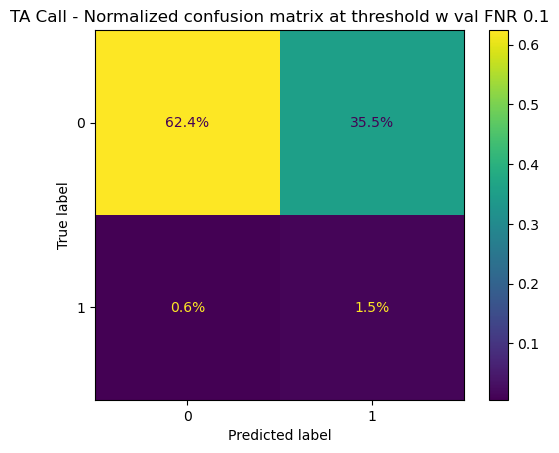

In [352]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
cm_normalized = cm.astype('float') / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(values_format=".1%")  # формат процентов
plt.title(f'TA Call - Normalized confusion matrix at threshold w val FNR 0.1')
plt.show()

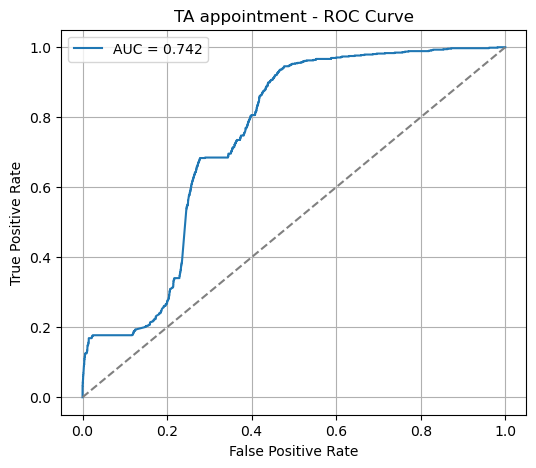

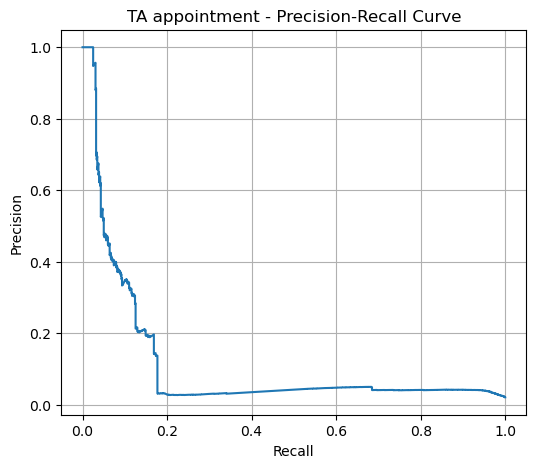

In [354]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f'TA {ta} - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# PR-кривая
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f'TA {ta} - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


### Reservation

#### Делим выборки

In [589]:
# [['call','appointment','reservation','deal']]

In [591]:
# train_full = final_data[final_data.report_date < '2024-12-08']
# val_full = final_data[final_data.report_date == '2024-12-08']
# test_full = final_data[final_data.report_date > '2024-12-08']

In [356]:
final_data.sort_values(by='delivery_date', inplace = True)

In [358]:
final_data.reset_index(drop=True, inplace = True)

In [ ]:
# train_full = final_data[final_data.report_date <= '2024-12-08']

In [1009]:
ta = 'reservation'

In [1011]:
reservation_full = final_data[final_data.target_event == ta]

In [1013]:
reservation_full.reset_index(drop=True, inplace = True)

In [1015]:
train_full = reservation_full[:40000]

In [1017]:
# train_full = final_data[final_data.report_date <= '2024-12-08']

In [1019]:
X_train = train_full[train_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

y_train = train_full[train_full.target_event == ta][[ta]].to_numpy()

In [1020]:
test_full = reservation_full[40000:]

In [1023]:
X_test = test_full[test_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

y_test = test_full[test_full.target_event == ta][[ta]].to_numpy()

In [1025]:
# X_val = val_full[val_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
#     ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

# y_val = val_full[val_full.target_event == ta][[ta]].to_numpy()

In [1027]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [1028]:
len(test_full), len(train_full) 

(8711, 40000)

#### Обучаем модель

In [1283]:
cat_features = [360, 361, 362, 363]

In [1285]:
# params = {
#     # база для любой модели
#     'iterations':   50,
#     'learning_rate': 0.05,
#     'random_state':42,
#     'verbose':100,
#     'cat_features':cat_features,
#     'loss_function': 'CrossEntropy',
#     # боремся с переобучением
#     # 'early_stopping_rounds': 50,
#     'depth':         12,
#     'l2_leaf_reg':   50,
# }

In [1287]:
params = {
    # база для любой модели
    'iterations':   100,
    'learning_rate': 0.05,
    'random_state':42,
    'verbose':100,
    'cat_features':cat_features,
    'loss_function': 'CrossEntropy',
    # боремся с переобучением
    # 'early_stopping_rounds': 50,
    'depth':         10,
    'l2_leaf_reg':   50,
}

In [1289]:
# del eval_pool

In [1291]:
# eval_pool = Pool(X_val, y_val, cat_features=cat_features)

In [1293]:
res_model = CatBoostClassifier(**params)

In [1295]:
res_model.fit(X_train, y_train
               , plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5949482	total: 65.6ms	remaining: 6.5s
99:	learn: 0.0485716	total: 7.11s	remaining: 0us


In [1296]:
# CM
# True Negative False Positive
# False Negative True Positive

# Precision - доля корректно отгаданных 1 относительно всех признанных 1
# Recall - доля корректно отгаданных 1 среди всех 1 в выборке

# Чем больше Precision, тем больше уверенности в случае, когда мы признали 1 
# Чем больше Recall, тем больше 1 мы угадали

In [1297]:
fnr_boundary = select_threshold(model=res_model, data=train_pool, FNR=0.1)

Cannot restore border parameter, falling to default border = 0.5


In [1298]:
res_model.set_probability_threshold(fnr_boundary)

In [1322]:
res_model.save_model('model_res.bin')
# call_model = CatBoostClassifier()
# call_model.load_model('model_call.bin')
# print(call_model.get_params())

#### Считаем метрики

In [1301]:
# Train сет

In [1302]:
probs = res_model.predict_proba(X_train)[:,1]
preds = res_model.predict(X_train)

In [1303]:
model_metrics(probs,preds,y_train)


AUC:     0.925
Accuracy:  0.766
Precision: 0.050
Recall:    0.901
F1 Score:  0.094


In [1304]:
# Test сет

In [1305]:
probs = res_model.predict_proba(X_test)[:,1]
preds = res_model.predict(X_test)

In [1306]:
model_metrics(probs,preds,y_test)


AUC:     0.711
Accuracy:  0.754
Precision: 0.007
Recall:    0.424
F1 Score:  0.013


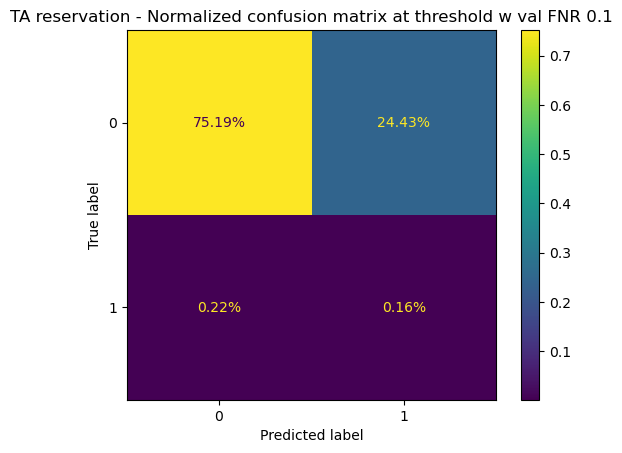

In [1307]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
cm_normalized = cm.astype('float') / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(values_format=".2%")  # формат процентов
plt.title(f'TA {ta} - Normalized confusion matrix at threshold w val FNR 0.1')
plt.show()

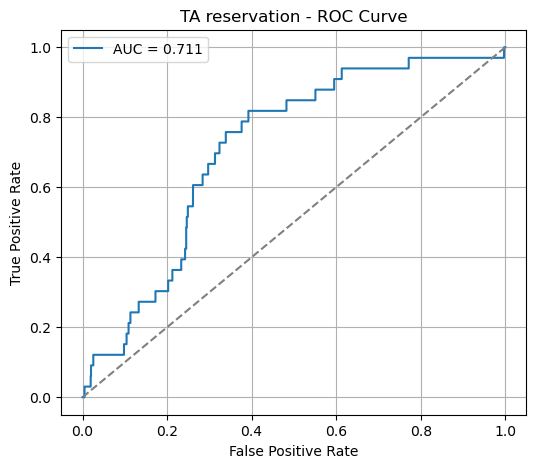

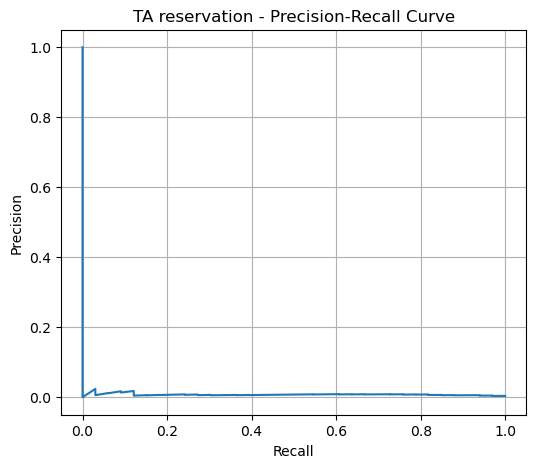

In [1308]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.3f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f'TA {ta} - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# PR-кривая
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f'TA {ta} - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


### Deal

#### Делим выборки

In [417]:
# [['call','appointment','reservation','deal']]

In [419]:
# поменяли даты, чтобы было с чем сравнить

In [1324]:
train_full = final_data[final_data.report_date < '2024-10-15']
# val_full = final_data[final_data.report_date == '2024-12-08']
test_full = final_data[final_data.report_date >= '2024-10-15']

In [1325]:
ta = 'deal'

In [1326]:
X_train = train_full[train_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

y_train = train_full[train_full.target_event == ta][[ta]].to_numpy()

In [1327]:
# X_val = val_full[val_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
#     ,'smt_decision_makerid' ,'report_date','delivery_date','previous_sunday']).to_numpy()

# y_val = val_full[val_full.target_event == ta][[ta]].to_numpy()

In [1330]:
X_test = test_full[test_full.target_event == ta].drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

y_test = test_full[test_full.target_event == ta][[ta]].to_numpy()

In [1331]:
len(X_train), len(X_test), 

(53468, 13025)

#### Обучаем модель

In [1366]:
cat_features = [360, 361, 362, 363]

In [1368]:
params = {
    # база для любой модели
    'iterations':   100,
    'learning_rate': 0.05,
    'random_state':42,
    'verbose':100,
    'cat_features':cat_features,
    'loss_function': 'CrossEntropy',
    # 'eval_metric':   'AUC',
    # боремся с переобучением
    # 'use_best_model': True,
    'early_stopping_rounds': 100,
    'depth':         10,
    'l2_leaf_reg':   10,
}

In [1370]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)

In [1371]:
# eval_pool = Pool(X_val, y_val, cat_features=cat_features)

In [1374]:
deal_model = CatBoostClassifier(**params)

In [1376]:
deal_model.fit(X_train, y_train,
        # eval_set=train_pool,
        plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5692203	total: 76.3ms	remaining: 7.55s
99:	learn: 0.0185528	total: 7.75s	remaining: 0us


In [1377]:
# CM
# True Negative False Positive
# False Negative True Positive

# Precision - доля корректно отгаданных 1 относительно всех признанных 1
# Recall - доля корректно отгаданных 1 среди всех 1 в выборке

# Чем больше Precision, тем больше уверенности в случае, когда мы признали 1 
# Чем больше Recall, тем больше 1 мы угадали

In [1378]:
fnr_boundary = select_threshold(model=deal_model, data=train_pool, FNR=0.1)

Cannot restore border parameter, falling to default border = 0.5


In [1379]:
deal_model.set_probability_threshold(fnr_boundary)

In [1380]:
deal_model.save_model('model_deal.bin')
# deal_model = CatBoostClassifier()
# deal_model.load_model('deal_model.bin')
# print(deal_model.get_params())

#### Считаем метрики

In [1382]:
# Train сет

In [1383]:
probs = deal_model.predict_proba(X_train)[:,1]
preds = deal_model.predict(X_train)

In [1384]:
model_metrics(probs,preds,y_train)


AUC:     0.957
Accuracy:  0.906
Precision: 0.045
Recall:    0.903
F1 Score:  0.086


In [1385]:
# Test сет

In [1386]:
probs = deal_model.predict_proba(X_test)[:,1]
preds = deal_model.predict(X_test)

In [1387]:
model_metrics(probs,preds,y_test)


AUC:     0.851
Accuracy:  0.745
Precision: 0.043
Recall:    0.846
F1 Score:  0.082


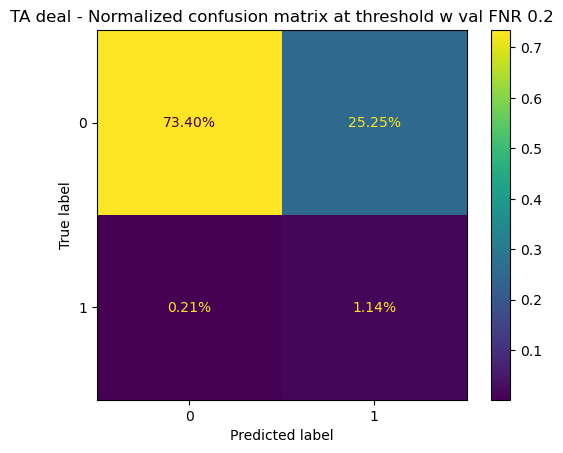

In [1395]:
# Confusion Matrix
cm = confusion_matrix(y_test, preds)
cm_normalized = cm.astype('float') / cm.sum()

disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized)
disp.plot(values_format=".2%")  # формат процентов
plt.title(f'TA {ta} - Normalized confusion matrix at threshold w val FNR 0.2')
plt.show()

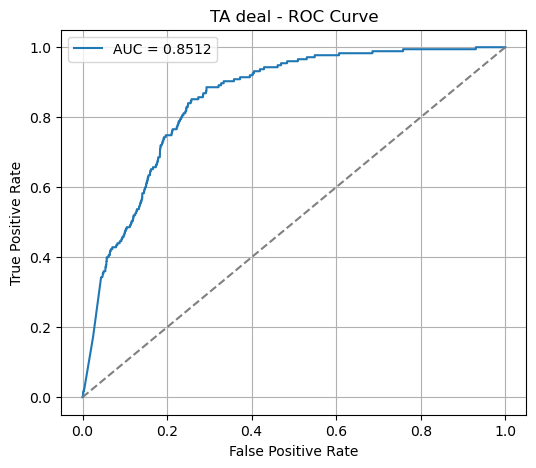

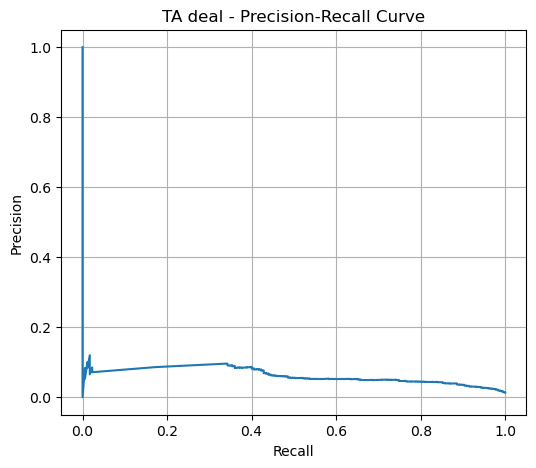

In [1403]:
# ROC-кривая
fpr, tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, probs):.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title(f'TA {ta} - ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
plt.show()

# PR-кривая
prec, rec, _ = precision_recall_curve(y_test, probs)
plt.figure(figsize=(6, 5))
plt.plot(rec, prec)
plt.title(f'TA {ta} - Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid()
plt.show()


# Часть 4. Валидация и результаты

### Предсказываю оффер для тестовой выборки

#### 1) Для каждого тестового юзера получаю ЦД из предсказаний модели склонностей

In [1406]:
df_res_1_step[['smt_decision_makerid','delivery_date','target_event','event_res']]

,smt_decision_makerid,delivery_date,target_event,event_res
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,call,call
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,call,call
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,call,call
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,call,call
4,42358f2cf5e091a253a54259e058b855,2024-12-18,call,appointment
...,...,...,...,...
169064,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,call,call
169065,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,call,call
169066,c2ff7b9060dbaf6535ff43e5e7dd80e4,2024-12-19,call,call
169067,997d06aa5ef9ecfdd074bb3d605f1ff6,2024-12-19,call,appointment


#### 2) Подготавливаю данные для скоринга - фичи клиента и комбинации фичей для коммуникаций под каждый таргет

In [1408]:
unique_offers = final_data[['target_event', 'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']].drop_duplicates().reset_index(drop=True).copy()

In [1410]:
df_for_scoring = df_res_1_step[df_res_1_step.target_event == df_res_1_step.event_res][['smt_decision_makerid','delivery_date','target_event']].copy()

In [1414]:
df_for_scoring.target_event.value_counts()

target_event
call           71992
appointment     4984
reservation       33
Name: count, dtype: int64

In [1416]:
df_for_scoring = df_for_scoring.merge(unique_offers, left_on = 'target_event', right_on = 'target_event')

In [1418]:
df_for_scoring.drop_duplicates(inplace=True)

In [1420]:
len(df_for_scoring)

297994

In [1422]:
test_full = final_data[final_data.report_date > '2024-12-08'].copy()

In [1424]:
test_full.drop_duplicates(inplace=True)

In [1425]:
len(test_full)

169066

In [1426]:
test_for_scoring_full = test_full.drop(columns = ['tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']).merge(df_for_scoring, 
                on = ['smt_decision_makerid','delivery_date','target_event']).drop_duplicates()

In [1429]:
len(test_for_scoring_full)

297994

In [1432]:
test_for_scoring_full.target_event.value_counts()

target_event
call           287968
appointment      9960
reservation        66
Name: count, dtype: int64

In [1434]:
X_call_scoring_full = test_for_scoring_full[test_for_scoring_full.target_event == 'call'].copy()

X_appointment_scoring_full = test_for_scoring_full[test_for_scoring_full.target_event == 'appointment'].copy() 

X_reservation_scoring_full = test_for_scoring_full[test_for_scoring_full.target_event == 'reservation'].copy() 

In [1435]:
X_call_scoring = X_call_scoring_full.drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

X_appointment_scoring = X_appointment_scoring_full.drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

X_reservation_scoring = X_reservation_scoring_full.drop(columns=['call','appointment','deal','reservation', 'target_event'
    ,'smt_decision_makerid','report_date','delivery_date','previous_sunday']).to_numpy()

In [1437]:
len(X_call_scoring[0]) == len(X_train[0])

True

#### 3) Запускаю модели, скорю юзеров и коммуникации

In [1439]:
y_scores_call = call_model.predict_proba(X_call_scoring)[:, 1]
y_scores_appointment = ap_model.predict_proba(X_appointment_scoring)[:, 1]
y_scores_reservation = res_model.predict_proba(X_reservation_scoring)[:, 1]

In [1440]:
X_call_scoring_full['y_score'] = y_scores_call
X_appointment_scoring_full['y_score'] = y_scores_appointment
X_reservation_scoring_full['y_score'] = y_scores_reservation

In [1441]:
for df in X_call_scoring_full, X_appointment_scoring_full, X_reservation_scoring_full:
    df['y_rn'] = df.groupby(['smt_decision_makerid', 'delivery_date'])['y_score']\
        .rank(method='first', ascending=False).astype(int)

In [1442]:
X_best_comms = pd.concat([X_call_scoring_full[X_call_scoring_full.y_rn==1], X_appointment_scoring_full[X_appointment_scoring_full.y_rn==1],
        X_reservation_scoring_full[X_reservation_scoring_full.y_rn==1]], ignore_index=True)

In [1443]:
# прогнозы коммуникаций с лучшими скорами
X_best_comms = X_best_comms[['smt_decision_makerid', 'delivery_date','target_event',
        'tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']].sort_values(by='smt_decision_makerid')

In [1444]:
X_best_comms

,smt_decision_makerid,delivery_date,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
35255,0001463504717134f55fecd5968138ee,2024-12-18,call,realestate,not_izhs,chain,not_model
67035,0001e4348a1b35205eeab60ce11502f4,2024-12-20,call,realestate,not_izhs,chain,not_model
69079,0002bc364f3b920afdbfeb72188fdd4c,2024-12-20,call,realestate,not_izhs,chain,not_model
20302,0003452a894844a4a7de026951c161a0,2024-12-18,call,realestate,not_izhs,chain,not_model
7117,000380b36f2861814e5403dc34da86ee,2024-12-16,call,realestate,not_izhs,chain,not_model
...,...,...,...,...,...,...,...
64516,fffba31a8402f9d3c46303111ec43a9a,2024-12-20,call,realestate,not_izhs,chain,not_model
2807,fffbd7ab36a12b6139cf4094f8d00499,2024-12-16,call,realestate,not_izhs,chain,not_model
45577,fffe5f81f2c32b01f533c1dd7e339b60,2024-12-18,call,realestate,not_izhs,chain,not_model
6302,fffe9e23dd7b471e69f6ad9fd82d5f80,2024-12-16,call,realestate,not_izhs,chain,not_model


In [1445]:
X_fact_comms = df_res_1_step[df_res_1_step.target_event == df_res_1_step.event_res][['smt_decision_makerid','delivery_date','target_event']].drop_duplicates() \
    .merge(test_full[['smt_decision_makerid','delivery_date','tag_product', 'tag_project_type', 'tag_chain_flag', 'tag_model_flag']].drop_duplicates())
X_fact_comms

,smt_decision_makerid,delivery_date,target_event,tag_product,tag_project_type,tag_chain_flag,tag_model_flag
0,a024eeadd2a9bc8597d91126a11df815,2024-12-18,call,realestate,not_izhs,chain,not_model
1,2e06f41ab8495ef1f51c014d62fa4698,2024-12-18,call,realestate,not_izhs,chain,not_model
2,45d087c08c8935951dbeca6b63c5acb7,2024-12-18,call,realestate,not_izhs,chain,not_model
3,9aed9813e6881f5a58d5a8c7158771b4,2024-12-16,call,realestate,not_izhs,chain,not_model
4,d342d79a5c293c0d85785d4cb836dd93,2024-12-16,call,realestate,not_izhs,chain,not_model
...,...,...,...,...,...,...,...
77126,9da83f91136b813925bc40addd70274b,2024-12-19,call,izhs,izhs,chain,not_model
77127,140e5c8794f09ec49131a9c965119467,2024-12-19,call,izhs,izhs,chain,not_model
77128,2fafb2d053c7d717ab053a5252ad8316,2024-12-19,call,izhs,izhs,chain,not_model
77129,3b6f4224c840b959d0ce6614a84dc6e0,2024-12-19,call,izhs,izhs,chain,not_model


In [1446]:
# разная длина, потому что могло быть отправлено >1 коммуникации
len(X_fact_comms), len(X_best_comms)

(77131, 77005)

#### 4) Сравнение target event

In [1448]:
# 1) сходимость предсказания target_event -> 46% случаев

In [1449]:
len(df_res_1_step[df_res_1_step.target_event == df_res_1_step.event_res]) / len(df_res_1_step)

0.4554885874997782

In [1450]:
df_res_1_step.target_event.value_counts()

target_event
call           113611
appointment     34217
reservation     21241
Name: count, dtype: int64

In [1451]:
df_res_1_step.event_res.value_counts()

event_res
call           113164
appointment     36007
deal            19823
reservation        75
Name: count, dtype: int64

In [1506]:
# что мы предсказали, когда в реальности был звонок
df_res_1_step[df_res_1_step.target_event == 'call'].event_res.value_counts()

event_res
call           71992
appointment    29354
deal           12227
reservation       38
Name: count, dtype: int64

In [1508]:
# что мы предсказали, когда в реальности была встреча
df_res_1_step[df_res_1_step.target_event == 'appointment'].event_res.value_counts()

event_res
call           24118
deal            5111
appointment     4984
reservation        4
Name: count, dtype: int64

In [1510]:
# что мы предсказали, когда в реальности была бронь
df_res_1_step[df_res_1_step.target_event == 'reservation'].event_res.value_counts()

event_res
call           17054
deal            2485
appointment     1669
reservation       33
Name: count, dtype: int64

#### 4) Сравнение всех тэгов

In [1513]:
# 2) сходимость тэгов по тем коммуникациям, где сошелся таргет ивент

In [1515]:
df_same_ta = pd.merge(X_best_comms, X_fact_comms, on = ['smt_decision_makerid','delivery_date','target_event'])
df_same_ta

,smt_decision_makerid,delivery_date,target_event,tag_product_x,tag_project_type_x,tag_chain_flag_x,tag_model_flag_x,tag_product_y,tag_project_type_y,tag_chain_flag_y,tag_model_flag_y
0,0001463504717134f55fecd5968138ee,2024-12-18,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model
1,0001e4348a1b35205eeab60ce11502f4,2024-12-20,call,realestate,not_izhs,chain,not_model,mortgage,not_izhs,not_chain,not_model
2,0002bc364f3b920afdbfeb72188fdd4c,2024-12-20,call,realestate,not_izhs,chain,not_model,mortgage,not_izhs,not_chain,not_model
3,0003452a894844a4a7de026951c161a0,2024-12-18,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model
4,000380b36f2861814e5403dc34da86ee,2024-12-16,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model
...,...,...,...,...,...,...,...,...,...,...,...
77126,fffba31a8402f9d3c46303111ec43a9a,2024-12-20,call,realestate,not_izhs,chain,not_model,mortgage,not_izhs,not_chain,not_model
77127,fffbd7ab36a12b6139cf4094f8d00499,2024-12-16,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model
77128,fffe5f81f2c32b01f533c1dd7e339b60,2024-12-18,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model
77129,fffe9e23dd7b471e69f6ad9fd82d5f80,2024-12-16,call,realestate,not_izhs,chain,not_model,realestate,not_izhs,chain,not_model


In [1517]:
df_same_ta.columns

Index(['smt_decision_makerid', 'delivery_date', 'target_event',
       'tag_product_x', 'tag_project_type_x', 'tag_chain_flag_x',
       'tag_model_flag_x', 'tag_product_y', 'tag_project_type_y',
       'tag_chain_flag_y', 'tag_model_flag_y'],
      dtype='object')

In [1519]:
df_same_ta['tag_product_same'] = (df_same_ta['tag_product_x'] == df_same_ta['tag_product_y']).astype(int)
df_same_ta['tag_project_type_same'] = (df_same_ta['tag_project_type_x'] == df_same_ta['tag_project_type_y']).astype(int)
df_same_ta['tag_chain_flag_same'] = (df_same_ta['tag_chain_flag_x'] == df_same_ta['tag_chain_flag_y']).astype(int)
df_same_ta['tag_model_flag_same'] = (df_same_ta['tag_model_flag_x'] == df_same_ta['tag_model_flag_y']).astype(int)

In [1521]:
df_same_ta['count_same'] = df_same_ta['tag_product_same'] + df_same_ta['tag_project_type_same'] \
    + df_same_ta['tag_chain_flag_same'] + + df_same_ta['tag_model_flag_same']

In [1523]:
df_same_ta['count_same'].value_counts()

count_same
4    57984
2    14236
3     4645
1      266
Name: count, dtype: int64

In [1525]:
for col in df_same_ta.columns:
    if 'same' in col:
        print(col)
        print(df_same_ta[col].value_counts(normalize = True))
        print('----------------------')

tag_product_same
tag_product_same
1    0.753031
0    0.246969
Name: proportion, dtype: float64
----------------------
tag_project_type_same
tag_project_type_same
1    0.930923
0    0.069077
Name: proportion, dtype: float64
----------------------
tag_chain_flag_same
tag_chain_flag_same
1    0.876638
0    0.123362
Name: proportion, dtype: float64
----------------------
tag_model_flag_same
tag_model_flag_same
1    0.999702
0    0.000298
Name: proportion, dtype: float64
----------------------
count_same
count_same
4    0.751760
2    0.184569
3    0.060222
1    0.003449
Name: proportion, dtype: float64
----------------------


In [1527]:
# Фильтрую только те случаи, когда с фактом совпало 6 и более тэгов

In [1529]:
df_for_test_check = df_same_ta[df_same_ta.count_same>=4][['smt_decision_makerid','delivery_date','target_event']]
df_for_test_check

,smt_decision_makerid,delivery_date,target_event
0,0001463504717134f55fecd5968138ee,2024-12-18,call
3,0003452a894844a4a7de026951c161a0,2024-12-18,call
4,000380b36f2861814e5403dc34da86ee,2024-12-16,call
5,00047cd660db68e9f67c7c75f2bb6bfd,2024-12-18,call
6,0004f4588d2f226f2aee0a9895b063b4,2024-12-18,call
...,...,...,...
77125,fff8453900572a69c1e53f8ace5bad89,2024-12-18,call
77127,fffbd7ab36a12b6139cf4094f8d00499,2024-12-16,call
77128,fffe5f81f2c32b01f533c1dd7e339b60,2024-12-18,call
77129,fffe9e23dd7b471e69f6ad9fd82d5f80,2024-12-16,call


In [1531]:
# оцениваю CR из коммуникации в TA

In [1533]:
df_for_test_check = df_for_test_check.merge(final_data[['smt_decision_makerid','report_date','delivery_date','call','appointment','reservation','deal']].copy())

In [1534]:
def get_target_value(row):
    return row[row['target_event']]

df_for_test_check['target_value'] = df_for_test_check.apply(get_target_value, axis=1)

In [1536]:
df_for_test_check.head()

,smt_decision_makerid,delivery_date,target_event,report_date,call,appointment,reservation,deal,target_value
0,0001463504717134f55fecd5968138ee,2024-12-18,call,2024-12-15,0,0,0,0,0
1,0003452a894844a4a7de026951c161a0,2024-12-18,call,2024-12-15,0,0,0,0,0
2,000380b36f2861814e5403dc34da86ee,2024-12-16,call,2024-12-15,0,0,0,0,0
3,00047cd660db68e9f67c7c75f2bb6bfd,2024-12-18,call,2024-12-15,0,0,0,0,0
4,0004f4588d2f226f2aee0a9895b063b4,2024-12-18,call,2024-12-15,0,0,0,0,0


In [1539]:
df_for_test_check['target_value'].value_counts()

target_value
0    57698
1      361
Name: count, dtype: int64

In [1541]:
df_for_test_check.groupby('target_event')['target_value'].mean()

target_event
appointment    0.201566
call           0.004484
reservation    0.000000
Name: target_value, dtype: float64

In [1543]:
all_test_cr = X_fact_comms.merge(final_data[['smt_decision_makerid','report_date',
        'delivery_date','call','appointment','reservation','deal']])

all_test_cr['target_value'] = all_test_cr.apply(get_target_value, axis=1)

all_test_cr.groupby('target_event')['target_value'].mean()

target_event
appointment    0.026511
call           0.005539
reservation    0.000000
Name: target_value, dtype: float64

# Выводы

In [1547]:
# Реализована система рекомендаций офферов на основании исторических данных об их успешности.

# 1. Целевое действие в коммуникации сходится в 46% случаев. 
# Модель гораздо реже рекомендует коммуникации, направленные на бронь. Вместо них чаще рекомендуем коммуникации, направленные на покупку и звонок.

# 2. B 75% случаев из 46 коммуникация совпадает полностью. Среди коммуникаций, которые полностью совпали, кратно выше CR во встречу, но на 10% меньше в звонок.

# 3. Заметили, что часто отправляются коммуникации, направленные на целевые действия, которые уже были совершены.
# Это либо точка роста, либо проблема разметки.
# Так или иначе, наш подход учитывает этот фактор и рассматривает только целевые действия, продвигающие юзера по воронке.

# Кажется, что в совокупности это хорошие сигналы для того, чтобы попробовать запустить модель в прод

# Основной критерий валидности для меня служит именно заинтересованность со стороны коллег из Самолёта